In [1]:
target = 'time'
training_mode = 'test'

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
from math import exp
from evaluation import print_feature_importances
from evaluation import plot_cm
from evaluation import print_cr
from evaluation import auc
from persistence import model_saver
from preprocessing import scale
from preprocessing import scale_other
from itertools import product
from apply_model import predict_for_testing

In [3]:
mem_bin_cutoffs = [50, 100, 200, 500, 1000, 2000, 10000, 20000, 50000, 100000]
mem_categories = {i:mem_bin_cutoffs[i] for i in range(len(mem_bin_cutoffs))}

In [4]:
print(mem_categories)

{0: 50, 1: 100, 2: 200, 3: 500, 4: 1000, 5: 2000, 6: 10000, 7: 20000, 8: 50000, 9: 100000}


In [5]:
time_bin_cutoffs = [60, 120, 300, 600, 1800, 3600, 14400, 43200]
time_categories = {i:time_bin_cutoffs[i] for i in range(len(time_bin_cutoffs))}

In [6]:
print(time_categories)

{0: 60, 1: 120, 2: 300, 3: 600, 4: 1800, 5: 3600, 6: 14400, 7: 43200}


# Loading model and associated data

In [7]:
save_path = '/glade/work/jdubeau/model-saves/time_forest_final2021-07-12-14:03/'

In [8]:
ms = model_saver()
ms.load(save_path)

In [9]:
notes, \
    model, model_df, \
    categories_dict, \
    X_features, X_train, \
    y_train_full, X_val, \
    y_val_full, X_test, \
    y_test_full = ms.get_all()

In [10]:
print(notes)

Time class forest, filling missing lat/lon with max value. Trained on train + val + test data. Grid searched on Casper Batch job. X values NOT scaled. Uses balanced class weights.


In [11]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 19,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 225,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}

In [12]:
print_feature_importances(X_features, model)

('PP', 1.961)
('SP', 1.171)
('BR', 0.928)
('rqst_timespan', 35.894)
('rqst_area_rect', 20.6)
('converted', 3.931)
('params_num', 16.379)
('grid_def_num', 2.064)
('level_num', 8.133)
('ds084.1', 2.465)
('ds631.1', 2.679)
('ds083.3', 1.427)
('ds094.0', 0.945)
('ds083.2', 1.424)


In [13]:
X_train_norm, X_val_norm, X_test_norm = scale(X_train, X_val, X_test)

In [14]:
if target == 'mem':
    y_train = np.ravel(y_train_full['mem_category'])
    y_val = np.ravel(y_val_full['mem_category'])
    y_test = np.ravel(y_test_full['mem_category'])
else:
    y_train = np.ravel(y_train_full['time_category'])
    y_val = np.ravel(y_val_full['time_category'])
    y_test = np.ravel(y_test_full['time_category'])

<Figure size 432x288 with 0 Axes>

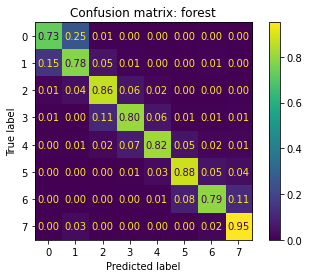

In [15]:
if training_mode == 'test':
    plot_cm(X_test_norm, y_test, model, save=False, path='class-forest-balanced.png')
else:
    plot_cm(X_val_norm, y_val, model)

In [16]:
if training_mode == 'test':
    print_cr(X_test_norm, y_test, model)
else:
    print_cr(X_val_norm, y_val, model)

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1813
           1       0.79      0.78      0.78      2681
           2       0.83      0.86      0.85      1947
           3       0.79      0.80      0.79      1401
           4       0.91      0.82      0.86      1983
           5       0.79      0.88      0.83       995
           6       0.89      0.79      0.84      1392
           7       0.56      0.95      0.71       342

    accuracy                           0.81     12554
   macro avg       0.79      0.83      0.80     12554
weighted avg       0.81      0.81      0.81     12554



In [17]:
if training_mode == 'test':
    auc(X_test_norm, y_test, model)
else:
    auc(X_val_norm, y_val, model)

0.9783540624378664


In [18]:
def custom_predict(X, model):
    probas = model.predict_proba(X)
    preds = []
    for entry in probas:
        first_guess = np.argmax(entry)
        first_proba = np.amax(entry)
        
        entry[first_guess] = 0
        second_guess = np.argmax(entry)
        second_proba = np.amax(entry)
        
        entry[second_guess] = 0
        third_guess = np.argmax(entry)
        third_proba = np.amax(entry)
        
        if first_proba > 0.7:
            preds.append(first_guess)
        else:
            preds.append(max([first_guess, second_guess, third_guess]))
    return np.array(preds)

In [19]:
dat = X_train_norm[:5]
pred = model.predict(dat)
prob = model.predict_proba(dat)
cpred = custom_predict(dat, model)

for i in range(5):
    print("Probas:")
    print([round(100*val, 1) for val in prob[i]])
    print("Normal prediction:")
    print(pred[i])
    print("Custom prediction:")
    print(cpred[i])
    print('-------')

Probas:
[0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normal prediction:
1
Custom prediction:
1
-------
Probas:
[0.0, 1.9, 98.0, 0.1, 0.0, 0.0, 0.0, 0.0]
Normal prediction:
2
Custom prediction:
2
-------
Probas:
[0.0, 0.0, 1.4, 3.1, 94.9, 0.1, 0.5, 0.0]
Normal prediction:
4
Custom prediction:
4
-------
Probas:
[5.4, 12.7, 71.5, 6.8, 2.9, 0.0, 0.4, 0.4]
Normal prediction:
2
Custom prediction:
2
-------
Probas:
[46.7, 10.4, 28.4, 7.1, 3.6, 1.5, 2.1, 0.3]
Normal prediction:
0
Custom prediction:
2
-------


In [20]:
def scale_predictions(preds, init_val=2.31, ten_pct_pt=1000):
    '''Scales predictions.
    
       First interprets the predicted category as a memory
       value.
       
       Then multiplies by a scaling value which begins
       at the init_val and decays for higher memory values,
       reaching a value of 1.1 (thus scaling by 10%) at the 
       given value called ten_pct_pt. 
       '''
    
    a = init_val - 1
    b = (1/ten_pct_pt)*math.log(0.1/a)
    
    sc_predictions = []
    for cat in preds:
        if target == 'mem':
            val = mem_categories[cat]
        else:
            val = time_categories[cat]
        val *= 1 + a*exp(b*val)
        val = round(val)
        sc_predictions.append(val)
    return sc_predictions

In [21]:
def evaluation_df(X, y_full, model, init_val=2.31, ten_pct_pt=1000):
    df = y_full.copy()
    if target == 'mem':
        df['mem_delta'] = df.apply(lambda row: 
                               row['req_mem'] - row['used_mem'],
                               axis=1)
        df['pred_cat'] = custom_predict(X, model)
        df['pred_mem'] = scale_predictions(df['pred_cat'],
                                           init_val=init_val,
                                           ten_pct_pt=ten_pct_pt)
        df['pred_delta'] = df.apply(lambda row: row['pred_mem'] - row['used_mem'],
                                    axis=1)
    else:
        df['time_delta'] = df.apply(lambda row: 
                               43200 - row['wall_time'],
                               axis=1)
        df['pred_cat'] = custom_predict(X, model)
        df['pred_time'] = np.array([min(43200, x) 
                                    for  x in
                                    scale_predictions(df['pred_cat'],
                                           init_val=init_val,
                                           ten_pct_pt=ten_pct_pt)])
        df['pred_delta'] = df.apply(lambda row: row['pred_time'] - row['wall_time'],
                                    axis=1)
    return df

In [22]:
init_val = 6.0
ten_pct_pt = 30000

if training_mode == 'test':
    df = evaluation_df(X_test_norm, y_test_full, model, init_val=init_val, ten_pct_pt=ten_pct_pt)
else:
    df = evaluation_df(X_val_norm, y_val_full, model, init_val=init_val, ten_pct_pt=ten_pct_pt)
    
df.sample(10)

,wall_time,time_category,time_delta,pred_cat,pred_time,pred_delta
6234797,149.0,2,43051.0,2,1742,1593.0
6542009,4109.0,6,39091.0,6,25411,21302.0
6319438,1070.0,4,42130.0,4,8917,7847.0
6764801,156.0,2,43044.0,2,1742,1586.0
6325955,35.0,0,43165.0,3,3374,3339.0
6225621,37.0,0,43163.0,0,358,321.0
6605834,155.0,2,43045.0,2,1742,1587.0
6444966,59.0,0,43141.0,2,1742,1683.0
6480085,48.0,0,43152.0,0,358,310.0
6618638,102.0,1,43098.0,3,3374,3272.0


In [24]:
def total_loss_info():
    print(f"Number of entries predicted: {df.shape[0]}")
    print("--------")
    print("Number of jobs using more mem/time than predicted: "
          + f"{df[df.pred_delta < 0].shape[0]}")
    print("Average delta for jobs using more than predicted: "
          + f"{round(df[df.pred_delta<0]['pred_delta'].mean(), 2)}")
    print("Sample of jobs using more mem/time than predicted: ")
    if target == 'mem':
        #print(df[df.pred_delta < 0][['used_mem', 'mem_category',
                                    #'pred_cat', 'pred_mem',
                                    #'pred_delta']].sample(5))
        print("--------")
        print("Total unused memory in GB (original): "
              + f"{round(df['mem_delta'].sum()/1024)}")
        print("Total unused memory in GB (predicted): "
              + f"{round(df[df.pred_delta >= 0]['pred_delta'].sum()/1024)}")
    else:
        print(df[df.pred_delta < 0][['wall_time', 'time_category',
                                    'pred_cat', 'pred_time',
                                    'pred_delta']].sample(5))
        print("--------")
        print("Total unused time in years (original): "
              + f"{round(df['time_delta'].sum()/31536000, 4)}")
        print("Total unused time in years (predicted): "
              + f"{round(df[df.pred_delta >= 0]['pred_delta'].sum()/31536000, 4)}")

In [25]:
total_loss_info()

Number of entries predicted: 12554
--------
Number of jobs using more mem/time than predicted: 55
Average delta for jobs using more than predicted: -23929.6
Sample of jobs using more mem/time than predicted: 
         wall_time  time_category  pred_cat  pred_time  pred_delta
6223141    82116.0              7         7      43200    -38916.0
6778768    78291.0              7         7      43200    -35091.0
6213310    50951.0              7         7      43200     -7751.0
6738690    52700.0              7         7      43200     -9500.0
6219603    48511.0              7         7      43200     -5311.0
--------
Total unused time in years (original): 16.3936
Total unused time in years (predicted): 5.8409


In [27]:
df.sort_values(by='pred_delta').head()

,wall_time,time_category,time_delta,pred_cat,pred_time,pred_delta
6236202,85608.0,7,-42408.0,7,43200,-42408.0
6242925,85336.0,7,-42136.0,7,43200,-42136.0
6246420,84688.0,7,-41488.0,7,43200,-41488.0
6772472,84084.0,7,-40884.0,7,43200,-40884.0
6236402,83832.0,7,-40632.0,7,43200,-40632.0


In [28]:
type(X_train_norm)

numpy.ndarray

In [29]:
testing_df = model_df.copy()
testing_X = scale_other(testing_df[X_features], X_train)
print(testing_X[:5])
print(testing_df[X_features].head(5))
testing_df['pred_time_nb'] = scale_predictions(custom_predict(testing_X, 
                                                            model),
                                             init_val=6,
                                             ten_pct_pt=30000)

[[ 0.45511025 -0.25862096 -0.34957241 -0.24856708 -0.81473114  1.24456177
  -0.51416695 -0.38445327 -0.28309505  1.34441332 -0.35805261 -0.25500837
  -0.25358807 -0.25571628]
 [ 0.45511025 -0.25862096 -0.34957241 -0.24856708 -0.81473114  1.24456177
  -0.51416695 -0.38445327 -0.28309505  1.34441332 -0.35805261 -0.25500837
  -0.25358807 -0.25571628]
 [ 0.45511025 -0.25862096 -0.34957241 -0.24856708 -0.81473114  1.24456177
  -0.51416695 -0.38445327 -0.28309505  1.34441332 -0.35805261 -0.25500837
  -0.25358807 -0.25571628]
 [ 0.45511025 -0.25862096 -0.34957241 -0.24856708 -0.81473114  1.24456177
  -0.51416695 -0.38445327 -0.28309505  1.34441332 -0.35805261 -0.25500837
  -0.25358807 -0.25571628]
 [ 0.45511025 -0.25862096 -0.34957241 -0.24856708 -0.81473114  1.24456177
  -0.51416695 -0.38445327 -0.28309505  1.34441332 -0.35805261 -0.25500837
  -0.25358807 -0.25571628]]
           PP     SP     BR  rqst_timespan  rqst_area_rect  converted  \
6132011  True  False  False         2132.5         

In [30]:
testing_df = predict_for_testing(testing_df)

In [32]:
testing_df[testing_df.pred_time_script != testing_df.pred_time_nb].shape

(61, 44)